In [86]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
import math
import seaborn as sns
import os

In [87]:
import os
def load_datasets():
    start_path = "C:/Users/talno/microbiom_project/all_datasets/"
    datasets = [x for x in os.listdir("C:/Users/talno/microbiom_project/all_datasets")]
    all_ibds, all_metas = [], []
    
    for name in datasets:
        subname = name[:-8]
        ibd = pd.read_csv(f'{start_path}{name}/RDP/{subname}.otu_table.100.denovo.rdp_assigned',sep='\t')
        try:
            meta = pd.read_csv(f'{start_path}{name}/{subname}.metadata.txt',sep='\t')
        except:
            meta = pd.read_csv(f'{start_path}{name}/{subname}.metadata.txt',sep='\t', encoding= 'unicode_escape')
        meta.rename(columns={meta.columns[0]: "#SampleID"}, inplace=True)
        all_ibds.append(ibd)
        all_metas.append(meta)
    return all_ibds, all_metas

all_names = [x[:-8] for x in os.listdir("C:/Users/talno/microbiom_project/all_datasets/")]
all_ibds, all_metas = load_datasets()

def clean(meta,ibd,name):
    
    otu = ibd.copy()
    otu["Unnamed: 0"] = otu["Unnamed: 0"].str.split(';', expand=True)[4] #+ '_' + otu["Unnamed: 0"].str.split(';', expand=True)[5]
    otu = otu.groupby(["Unnamed: 0"]).sum()
    try:
        otu.drop('f__', inplace=True)
    except Exception:
        print("no f__")
    otu = otu /otu.sum(axis = 0)
    otu.fillna(0,inplace=True)
    otu = otu.T
    meta.set_index("#SampleID", inplace=True)
    if name == 'crc_baxter':
        meta.index = meta.index.astype(str)
    keepsmpls = [i for i in otu.index if i in meta.index]
    otu = otu.loc[keepsmpls]
    meta = meta.loc[keepsmpls]
    otu = otu.join(meta.DiseaseState)
    otu.loc[:, "State"] = otu.loc[:, "DiseaseState"].map(
        {"ASD": "D", "nonCDI": "H", "nonIBD": "H", "CD": "D", "UC": "D", "CDI": "D", "H": "H", "postFMT_CDI": "H",
         "ASD": "D", 'HIV': "D", 'EDD': "D", "CRC": 'D', 'OB': "D", 'PAR': "D", "OW": "D", "CIRR": "D", "MHE": "D",
         "nonCRC": "H", "RA": "D", "T1D": "D", "PSA": "H", "nonCDI": "H", "nonCRC": "H", "NASH": "D", "CIRR": "D", "nonNASH-OB": "H"})
    otu["From"] = name
    return otu

fixed = []
for ibd, meta, name in zip(all_ibds, all_metas, all_names):
       fixed.append(clean(meta,ibd,name))
finish_data = pd.concat(fixed)
finish_data.fillna(0,inplace=True)
finish_data.drop(finish_data[finish_data.State == 0].index, inplace=True)
finish_data.drop(finish_data[finish_data.sum(axis=1) == 0].index, inplace=True)
finish_data.reset_index(drop=True, inplace=True)    
finish_data.to_csv("cleaned_microbiomeHD_29_f")

C:\Users\talno\AppData\Local\Temp\ipykernel_5148\2640211704.py:54: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  finish_data.drop(finish_data[finish_data.sum(axis=1) == 0].index, inplace=True)


MAKE THE WHOLE DATA - AMERICANS + MICROBIOMEHD

In [82]:
finish_data.to_csv("cleaned_microbiomeHD_29_f")

In [90]:
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/cleaned_microbiomeHD_29_f")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA_f", low_memory=False)

dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)

keep_features = [i for i in dataHD.columns if i in dataAmericans.columns]
n = len(keep_features)

dataHD_filtered = dataHD.loc[:,keep_features]
dataAmericans_filtered = dataAmericans.loc[:,keep_features]
print(dataAmericans_filtered.shape, dataHD_filtered.shape)

strong_features = dataHD_filtered.columns[(np.logical_or(dataHD_filtered.corrwith((dataHD.State == 'D')*1) > 0.01 , dataHD_filtered.corrwith((dataHD.State == 'D')*1) < -0.01)).values]
dataHD_filtered['From'] = dataHD.From
dataAmericans_filtered['From'] = 'americans'
all_data = pd.concat([dataHD_filtered, dataAmericans_filtered]).reset_index(drop=True)


(9509, 65) (4975, 65)


In [2]:
import pandas as pd

In [96]:
all_data.to_csv("all_data_f")

In [92]:
dataHD_filtered = dataHD.loc[:,keep_features]
dataAmericans_filtered = dataAmericans.loc[:,keep_features]
print(dataAmericans_filtered.shape, dataHD_filtered.shape)

(9509, 65) (4975, 65)


In [101]:
# plt.xticks(r + width/2,new_df.loc[:,'disease'], size=7)
len(dataHD_filtered.columns)

65

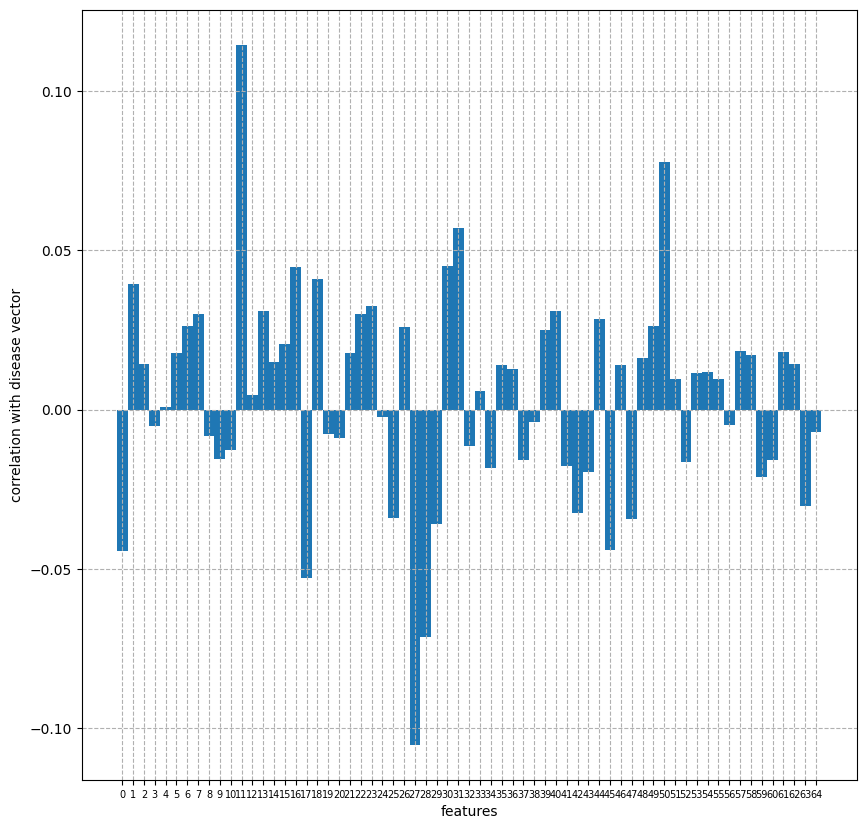

In [109]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10)) 
plt.bar(np.arange(0,dataHD_filtered.shape[1]), height=dataHD_filtered.corrwith((dataHD.State == 'D')*1), width=1)
plt.xticks(np.arange(0, dataHD_filtered.shape[1]), size=7) #, list(dataHD_filtered.columns), rotation=45, size=6)
plt.xlabel('features')
plt.ylabel('correlation with disease vector')
plt.grid(linestyle='--')
plt.show()


we built genus-level random forest classifiers to classify cases from controls within each study

In [110]:
dataHD_filtered.columns[11]

'f__Enterobacteriaceae'

C:\Users\talno\AppData\Local\Temp\ipykernel_5148\743375639.py:3: RuntimeWarning: divide by zero encountered in log
  p1 = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues", ax=axes[0])
C:\Users\talno\AppData\Local\Temp\ipykernel_5148\743375639.py:4: RuntimeWarning: divide by zero encountered in log
  p2 = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues", ax=axes[1])


Text(0.5, 0.995, '-log heatmap of microbiomeHD vs AmericanGut')

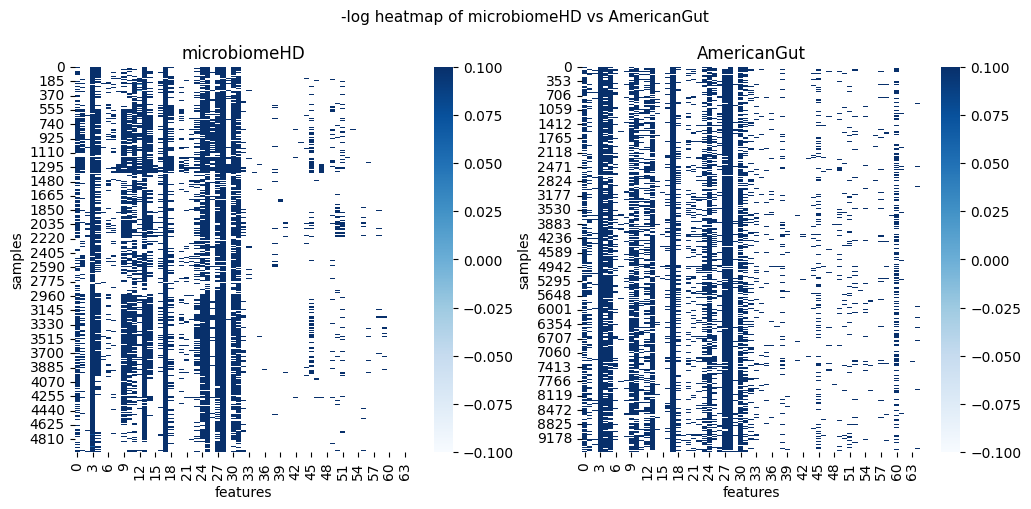

In [94]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
p1 = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues", ax=axes[0])
p2 = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues", ax=axes[1])

p1.set_xlabel('features')
p1.set_ylabel('samples')
p2.set_xlabel('features')
p2.set_ylabel('samples')

axes[0].set_title("microbiomeHD")
axes[1].set_title("AmericanGut")

fig.suptitle(f"-log heatmap of microbiomeHD vs AmericanGut", x=0.5, y=0.995, fontsize=11)
# plt.show()

C:\Users\talno\AppData\Local\Temp\ipykernel_5148\1963859689.py:4: RuntimeWarning: divide by zero encountered in log
  p1 = seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
C:\Users\talno\AppData\Local\Temp\ipykernel_5148\1963859689.py:5: RuntimeWarning: divide by zero encountered in log
  p2 = seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])


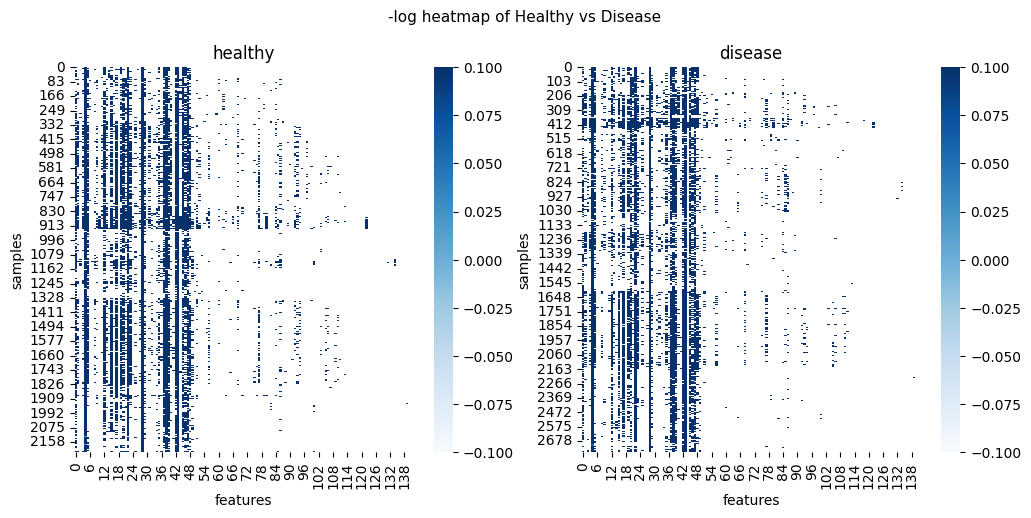

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
Healthy = dataHD.query("State == 'H'").drop(columns=["DiseaseState","State", "From"])
Disease = dataHD.query("State == 'D'").drop(columns=["DiseaseState","State", "From"])
p1 = seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
p2 = seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])

p1.set_xlabel('features')
p1.set_ylabel('samples')
p2.set_xlabel('features')
p2.set_ylabel('samples')

axes[0].set_title("healthy")
axes[1].set_title("disease")

fig.suptitle(f"-log heatmap of Healthy vs Disease", x=0.5, y=0.995, fontsize=11)
plt.show()